In [1]:
import tensorflow as tf
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imutils
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dropout, Dense

IMG_SIZE = 224

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("MyDrive/Bitirme/dataset1.zip", 'r')
zip_ref.extractall("/gdrive/MyDrive/Bitirme/dataset/")
zip_ref.close()

In [5]:
os.chdir("/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset")

In [6]:
num_skipped = 0

os.chdir("/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset")
for class_name in('train', 'test'):
  for folder_name in('NonDemented', 'VeryMildDemented','MildDemented', 'ModerateDemented'):
    folder_path = os.path.join(class_name, folder_name)

    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)

      try:
        fobj = open(fpath, 'rb')
        is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1

print('Deleted %d images' % num_skipped)

Deleted 0 images


In [7]:
train_path = 'train'
test_path = 'test'

classes = os.listdir(train_path) 

os.mkdir('/content/Train-Data')
os.mkdir('/content/Test-Data')

for cls in classes:
  os.mkdir(f'/content/Train-Data/{cls}')
  os.mkdir(f'/content/Test-Data/{cls}')

In [8]:
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [9]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_path, cls, x), os.listdir(os.path.join(train_path, cls)))) for cls in classes}

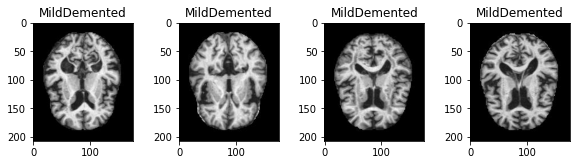

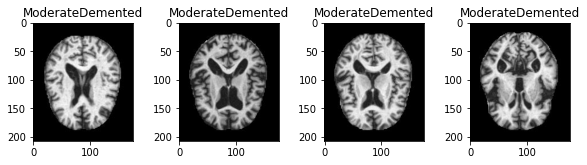

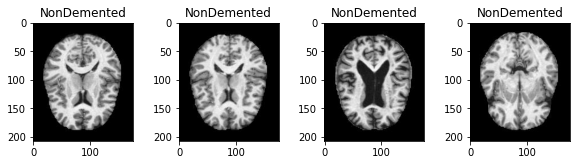

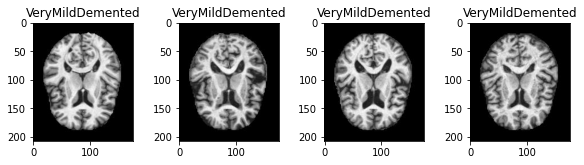

In [10]:
for cls in classes:
  plt.figure(figsize=(10, 10))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

In [11]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [12]:
train_class_paths = [os.path.join(train_path, cls) for cls in classes]

test_class_paths = [os.path.join(test_path, cls) for cls in classes]

In [13]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = '/content'

  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        save_class = cls.split('/')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [14]:
crop_img_saver(train_class_paths, save_dir='Train-Data')

crop_img_saver(test_class_paths, save_dir='Test-Data')

717it [00:02, 255.26it/s]
52it [00:00, 224.32it/s]
2560it [00:09, 266.56it/s]
1792it [00:06, 271.94it/s]
179it [00:00, 272.31it/s]
12it [00:00, 223.40it/s]
640it [00:02, 243.44it/s]
448it [00:02, 177.98it/s]


In [52]:
train_data_generator = ImageDataGenerator(rotation_range=20, 
                                          height_shift_range=0.15, 
                                          horizontal_flip=True, 
                                          vertical_flip=True,
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory('/content/Train-Data/',
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory('/content/Train-Data',
                                                           target_size=(IMG_SIZE, IMG_SIZE),
                                                           batch_size=8,
                                                           class_mode='categorical',
                                                           subset='validation')

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory('/content/Test-Data/',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        shuffle=False,
                                        class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [53]:
print(train_data.class_indices, test_data.class_indices, sep='\n')
labels = ['MildDemented', 'ModerateDemented','NonDemented', 'VeryMildDemented']

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


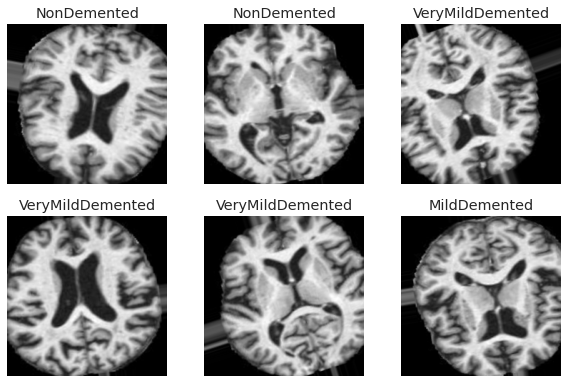

In [54]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(10, 10))
for i in range(6):
  plt.subplot(3, 3, i + 1)
  plt.axis('off'), plt.grid(False)
  plt.imshow(array_to_img(sample_x[i]))
  for j in range(4):
    if(sample_y[i][j]==1):
      plt.title(labels[j])
      break

In [55]:
from tensorflow.keras.applications import EfficientNetV2S

effnet = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.25)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [56]:
def scheduler(epoch, lr):
  lr=1e-4
  if epoch < 15:
    return lr
  elif epoch >= 15 and epoch < 30:
    return lr*(0.3)
  elif epoch >= 30 and epoch < 40:
    return lr*(0.3)*(0.3)
  else:
    return lr*(0.3)*(0.3)*(0.3)

In [57]:
epoch = 50
lr=1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  mode='auto',
                                                  verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5', 
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='auto',
                                                verbose=1)

In [58]:
epoch = 50
history = model.fit(train_data, 
                    epochs=epoch, 
                    validation_data=validation_data, 
                    callbacks=[callback, checkpoint], 
                    verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
513/513 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.5764
Epoch 1: val_accuracy improved from -inf to 0.41447, saving model to model_ckpt.h5
513/513 [==============================] - 126s 204ms/step - loss: 0.9549 - accuracy: 0.5764 - val_loss: 1.2210 - val_accuracy: 0.4145 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/50
513/513 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.6781
Epoch 2: val_accuracy improved from 0.41447 to 0.51417, saving model to model_ckpt.h5
513/513 [==============================] - 101s 197ms/step - loss: 0.7318 - accuracy: 0.6781 - val_loss: 1.0934 - val_accuracy: 0.5142 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/50
513/513 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.7562
Epoch 3: val_accuracy improved from 0.51417 

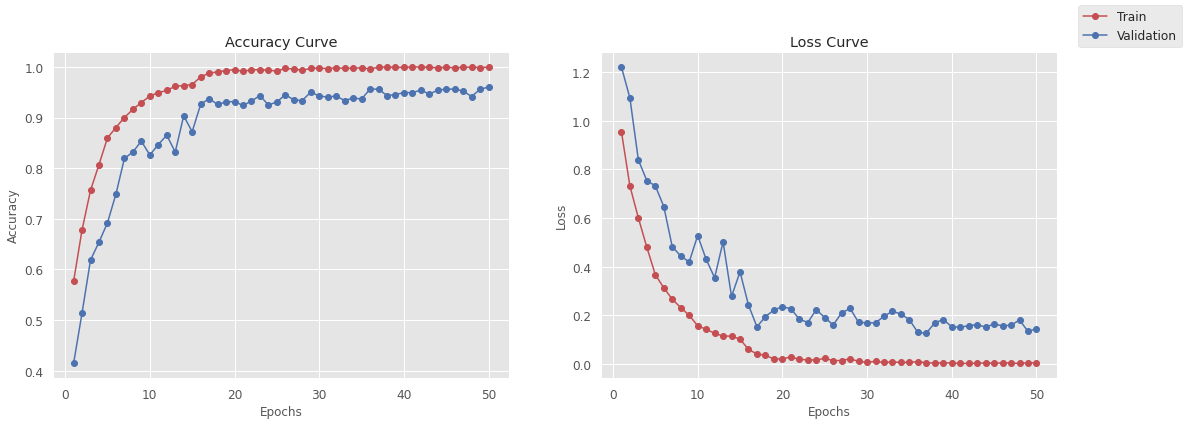

In [59]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, epoch + 1)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

In [60]:
acc = model.evaluate(test_data)
acc

40/40 [==============================] - 5s 130ms/step - loss: 0.7721 - accuracy: 0.8272


[0.7720937728881836, 0.8272087574005127]

In [61]:
from numpy import loadtxt
from keras.models import load_model

my_model = load_model('model_ckpt.h5')

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

test_data.reset()
y_pred = model.predict(test_data, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print('\nConfusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print()
print()
print('Classification Report')
target_names = labels
print(classification_report(test_data.classes, y_pred, target_names=target_names))

40/40 [==============================] - 7s 123ms/step

Confusion Matrix
[[134   0  26  19]
 [  3   8   1   0]
 [  7   0 591  42]
 [ 27   0  96 325]]


Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.78      0.75      0.77       179
ModerateDemented       1.00      0.67      0.80        12
     NonDemented       0.83      0.92      0.87       640
VeryMildDemented       0.84      0.73      0.78       448

        accuracy                           0.83      1279
       macro avg       0.86      0.77      0.80      1279
    weighted avg       0.83      0.83      0.82      1279



In [63]:
model.save('/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset/Models/prototype_model.h5')

In [65]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_images_path = '/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset/test2/'

for i in os.listdir(test_images_path):
  if not i.endswith('.jpg'):
    continue
    
  test_image = cv2.imread(test_images_path + i)
  test_image = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
  test_image = np.expand_dims(test_image, axis=0)

  pred = my_model.predict(test_image)
  mildDem=pred[0][0]
  modDem=pred[0][1]
  nonDem=pred[0][2]
  veryMildDem=pred[0][3]
  print("Sağlıklı olma olasılığı                 : ", end="")
  print("{0:.8f}".format(nonDem))
  print("Çok hafif Alzheimer bulunma olasılığı   : ", end="")
  print("{0:.8f}".format(veryMildDem))
  print("Hafif Alzheimer bulunma olasılığı       : ", end="")
  print("{0:.8f}".format(mildDem))
  print("Gelişmiş Alzheimer bulunma olasılığı    : ", end="")
  print("{0:.8f}".format(modDem))
  
  pred = np.argmax(pred)
  pred = label_map[pred]
  print(f'Görsel ismi: {i}')
  print(f'Tahmin edilen sınıf: {pred} \n')

1/1 [==============================] - 0s 38ms/step
Sağlıklı olma olasılığı                 : 0.00000554
Çok hafif Alzheimer bulunma olasılığı   : 0.99994493
Hafif Alzheimer bulunma olasılığı       : 0.00000041
Gelişmiş Alzheimer bulunma olasılığı    : 0.00004915
Görsel ismi: mod (4).jpg
Tahmin edilen sınıf: VeryMildDemented 

1/1 [==============================] - 0s 34ms/step
Sağlıklı olma olasılığı                 : 0.00008476
Çok hafif Alzheimer bulunma olasılığı   : 0.89945281
Hafif Alzheimer bulunma olasılığı       : 0.00016960
Gelişmiş Alzheimer bulunma olasılığı    : 0.10029288
Görsel ismi: mod (5).jpg
Tahmin edilen sınıf: VeryMildDemented 

1/1 [==============================] - 0s 36ms/step
Sağlıklı olma olasılığı                 : 0.99999738
Çok hafif Alzheimer bulunma olasılığı   : 0.00000000
Hafif Alzheimer bulunma olasılığı       : 0.00000189
Gelişmiş Alzheimer bulunma olasılığı    : 0.00000075
Görsel ismi: non (2).jpg
Tahmin edilen sınıf: NonDemented 

1/1 [=============